# Planar data classification with one hidden layer

**You will learn how to:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation


In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
#testCases_v2
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

In [2]:
X, Y = load_planar_dataset() 
#print(X)
print(X.shape)
#X含有400个样本，每个样本2个特征
print(Y.shape)

(2, 400)
(1, 400)


(1, 400)
(400,)


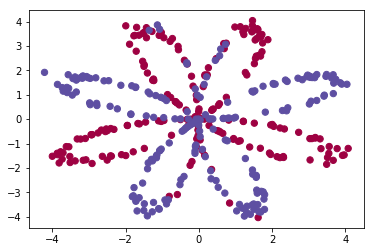

In [6]:
# Visualize the data: 
#X的第一行第二行，
#s标量或数组，c色彩，cmap：colormap
#plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);
#修改代码，可能是y的标签没有“factor”，np.squeeze(Y)
print(Y.shape)
print(np.squeeze(Y).shape)
plt.scatter(X[0, :], X[1, :],c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral)

In [7]:
### START CODE HERE ### (3 lines of code) 
shape_X = X.shape 
shape_Y = Y.shape 
m = shape_X[1] 
# training et size 
### END CODE HERE ###
print ('The shape of X is: ' + str(shape_X)) 
print ('The shape of Y is: ' + str(shape_Y)) 
print ('I have m = %d training examples.' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples.


In [8]:
## 先用logistic回归(使用sklearn里的)，看看分类效果

In [12]:
# Train the logistic regression classifier 
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)

C:\Users\congy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

### 画决策边界

Text(0.5,1,'Logistic Regression')

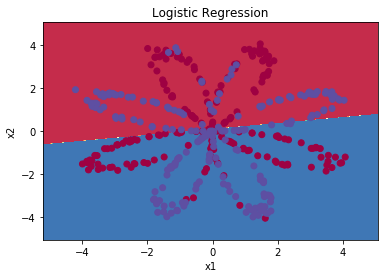

In [14]:
# Plot the decision boundary for logistic regression
#plot_decision_boundary(lambda x: clf.predict(x), X, Y) 
#clf.predict(x)
plot_decision_boundary(lambda x: clf.predict(x), X, np.squeeze(Y)) 
plt.title("Logistic Regression")

In [18]:
# Print accuracy
LR_predictions = clf.predict(X.T)
#print(Y.shape)：(1, 400)
#print(LR_predictions.shape):(400,)
#所以计算损失函数时，不需要转置。
print ('Accuracy of logistic regression: %d ' % 
       float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

(1, 400)
Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


### Interpretation: 
The dataset is not linearly separable, so logistic regression doesn’t perform well. Hopefully a neural network will do better. Let’s try this now!


## Neural Network model

**Here is our model**:
<img src="image/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

In [140]:
# GRADED FUNCTION: layer_sizes
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer，即每个隐藏层的单元数,默认为4
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0]# size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [141]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    Returns:
    params -- python dictionary containing your parameters:
    W1 -- weight matrix of shape (n_h, n_x)
    b1 -- bias vector of shape (n_h, 1)
    W2 -- weight matrix of shape (n_y, n_h)
    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h,n_x) * 0.01 
    b1 = np.zeros((n_h,1)) 
    W2 = np.random.randn(n_y,n_h)* 0.01 
    b2 = np.zeros((n_y,1))
    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [142]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"] 
    b1 = parameters["b1"] 
    W2 = parameters["W2"] 
    b2 = parameters["b2"] 
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = np.dot(W1,X)+b1 
    A1 = np.tanh(Z1) 
    Z2 = np.dot(W2,A1)+b2 
    A2 = sigmoid(Z2) 
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [143]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    #logprobs = np.multiply(np.log(A2),Y)+np.multiply(np.log(1-A2),1-Y)
    #cost = - np.sum(logprobs)/m
    #因为np.dot(W,x1)==np.sum(np.multiply(W,x1))，所以上面两行代码改为：
    cost = - (np.dot(Y,np.log(A2.T))+np.dot(np.log(1-A2),(1-Y).T))/m
    #[[]]
    cost = cost[0][0]

    ### END CODE HERE ###
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    return cost

**Instructions**:
Backpropagation is usually the hardest (most mathematical) part in deep learning. To help you, here again is the slide from the lecture on backpropagation. You'll want to use the six equations on the right of this slide, since you are building a vectorized implementation.  

<img src="image/grad_summary.png" style="width:600px;height:300px;">
* g：指激活函数，g'：激活函数的导数
    * 第一层激活函数：a=tanh(z)，其导数：1-a^2
    * 第二层激活函数：a=sigmoid(z),其导数，a(1-a)
- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.
    * A1=tanh(Z1)

In [144]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters["W1"] 
    W2 = parameters["W2"] 
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache["A1"] 
    A2 = cache["A2"]
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2 = A2-Y
    dW2 = np.dot(dZ2,A1.T)/m
    db2 = np.sum(dZ2,axis=1,keepdims=True)/m 
    dZ1 = np.dot(W2.T,dZ2)*(1 - np.power(A1, 2)) 
    dW1 = np.dot(dZ1,X.T)/m 
    db1 = np.sum(dZ1,axis=1,keepdims=True)/m 
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [145]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"] 
    b1 = parameters["b1"] 
    W2 = parameters["W2"] 
    b2 = parameters["b2"] 
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads["dW1"] 
    db1 = grads["db1"] 
    dW2 = grads["dW2"] 
    db2 = grads["db2"] 
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1-learning_rate*dW1 
    b1 = b1-learning_rate*db1 
    W2 = W2-learning_rate*dW2 
    b2 = b2-learning_rate*db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### Merge all functions into a model 

In [134]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    #没有使用n_h=4
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### START CODE HERE ### (≈ 5 lines of code)
    parameters = initialize_parameters(n_x, n_h, n_y) 
    W1 = parameters["W1"] 
    b1 = parameters["b1"] 
    W2 = parameters["W2"] 
    b2 = parameters["b2"] 
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost =  compute_cost(A2, Y, parameters)
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads =  backward_propagation(parameters, cache, X, Y)
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters =  update_parameters(parameters, grads)
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [146]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters) 
    predictions = np.round(A2)
    ### END CODE HERE ###
    return predictions

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219528
Cost after iteration 9000: 0.218627


Text(0.5,1,'Decision Boundary for hidden layer size 4')

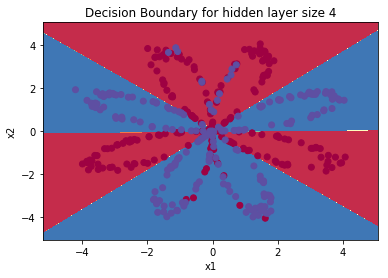

In [136]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
plt.title("Decision Boundary for hidden layer size " + str(4))

In [138]:
# Print accuracy
predictions = predict(parameters, X)
print(predictions.shape)
print(Y.shape)
#np.dot(Y,predictions.T)代表预测对1的个数，
#np.dot(1-Y,1-predictions.T)代表预测对0的个数
print ('Accuracy: %d' % 
       float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
       + '%')

(1, 400)
(1, 400)
Accuracy: 90%


## Tuning hidden layer size (optional/ungraded exercise)

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 10 hidden units: 90.25 %
Accuracy for 20 hidden units: 90.5 %
Accuracy for 21 hidden units: 91.0 %
Accuracy for 22 hidden units: 91.0 %
Accuracy for 41 hidden units: 91.0 %
Accuracy for 42 hidden units: 90.75 %


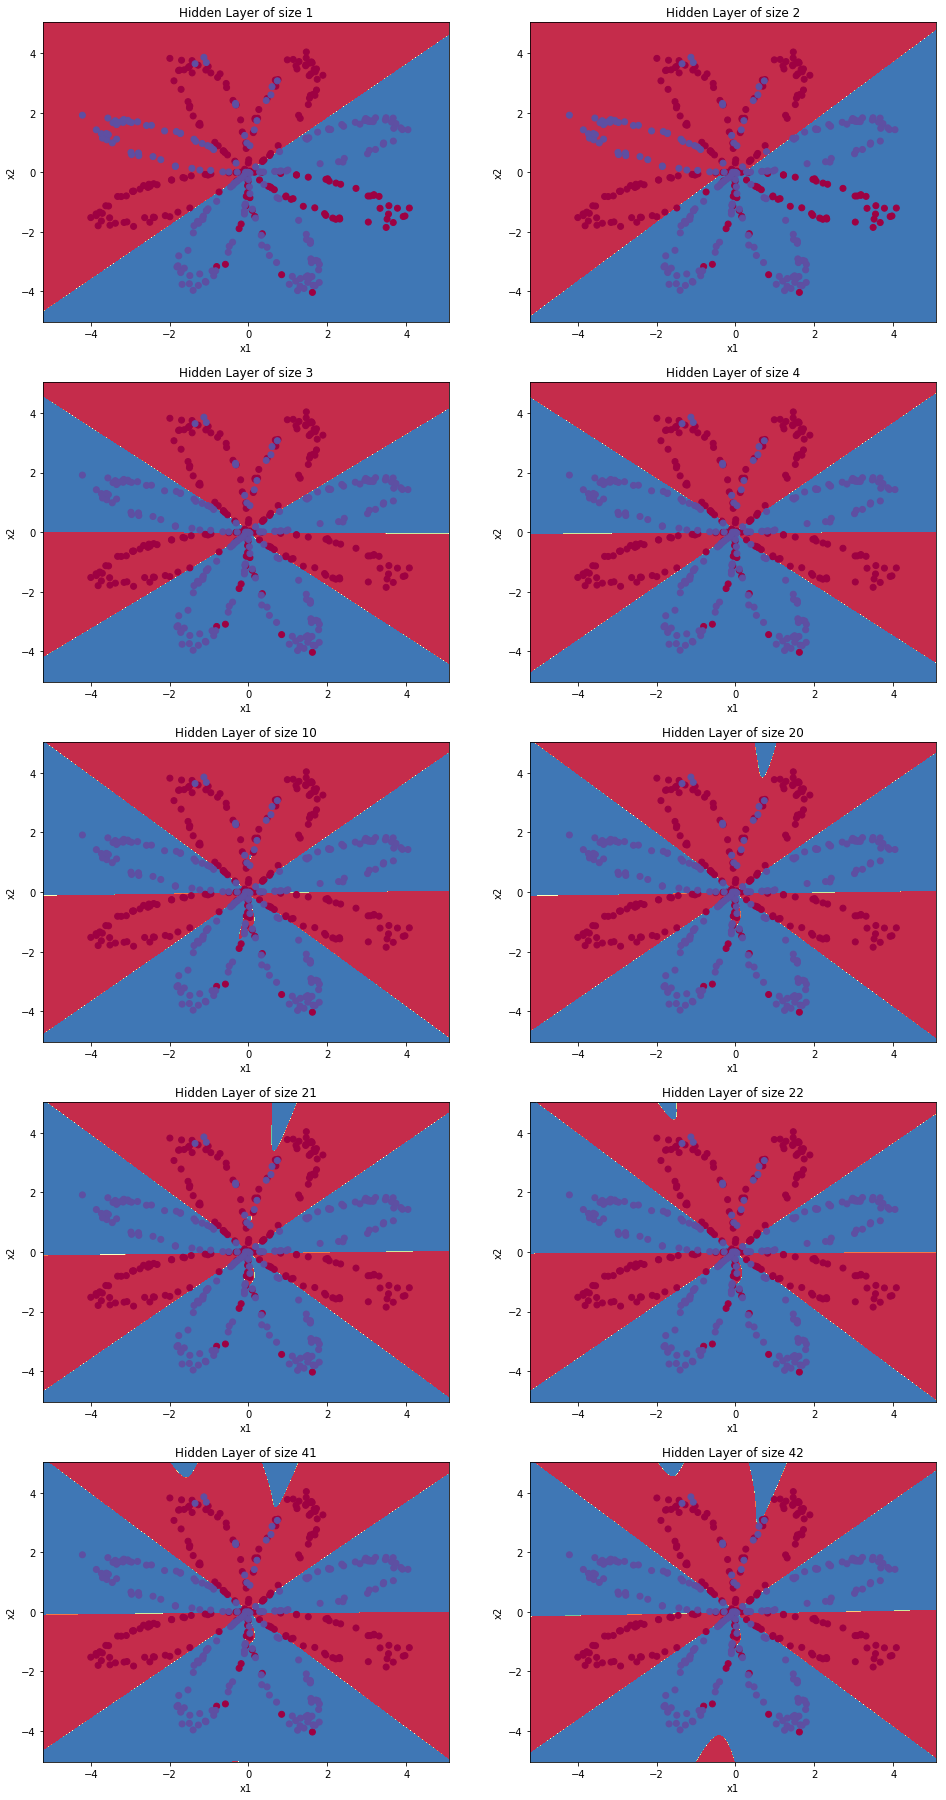

In [149]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 10, 20,21,22,41,42]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.squeeze(Y))
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))
#从图中看，隐藏层时偶数时，好像和奇数时没有什么改变，如2与1，4与3，5与6
#从数字角度看，也差别不大。